## Importing the dataset

In [2]:
from torchvision import datasets, transforms

# define transformation
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform)

test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

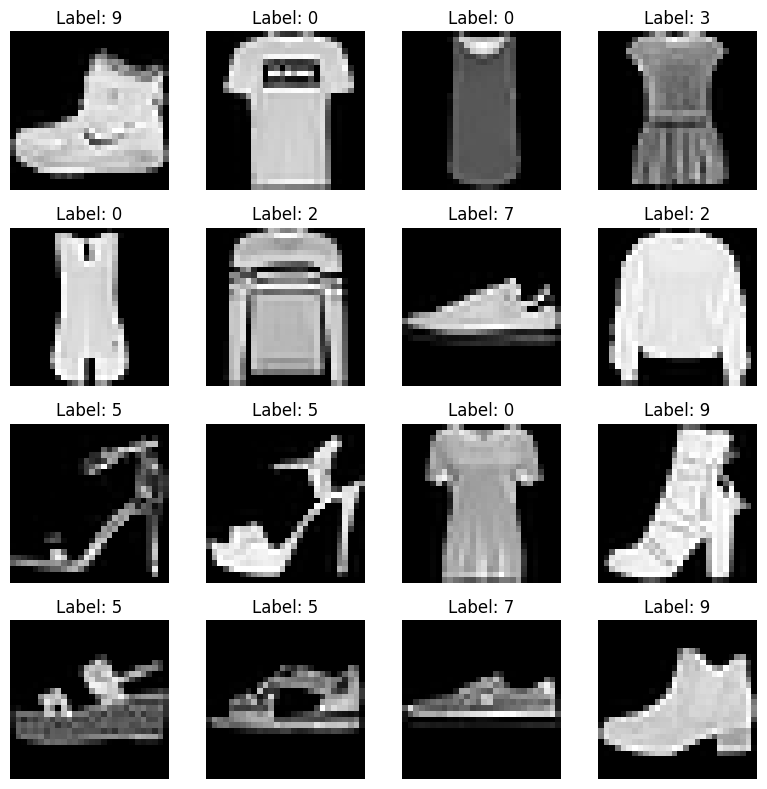

In [3]:
import matplotlib.pyplot as plt

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

## Importing packages

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pickle
import seaborn as sns

## Dense Layer

In [5]:
class DenseLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.001):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)
        self.learning_rate = learning_rate
    
    def forward(self, input, training=True):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        
        # Update weights and biases using gradient descent
        self.weights -= self.learning_rate * self.grad_weights
        self.bias -= self.learning_rate * self.grad_bias
        
        return grad_input

    def get_parameters(self):
        return [{'value': self.weights, 'grad': self.grad_weights},
                {'value': self.bias, 'grad': self.grad_bias}]


## Batch Norm Layer

In [6]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9, learning_rate=0.001):
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.ones((1, input_dim))
        self.learning_rate = learning_rate

    def forward(self, x, training=True):
        if training:
            batch_mean = np.mean(x, axis=0, keepdims=True)
            batch_var = np.var(x, axis=0, keepdims=True)
            self.x_centered = x - batch_mean
            self.stddev_inv = 1. / np.sqrt(batch_var + self.epsilon)
            x_norm = self.x_centered * self.stddev_inv
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            x_centered = x - self.running_mean
            x_norm = x_centered / np.sqrt(self.running_var + self.epsilon)
        
        out = self.gamma * x_norm + self.beta
        return out

    def backward(self, grad_output):
        batch_size = grad_output.shape[0]
        x_norm = self.x_centered * self.stddev_inv
        grad_gamma = np.sum(grad_output * x_norm, axis=0, keepdims=True)
        grad_beta = np.sum(grad_output, axis=0, keepdims=True)
        grad_x_norm = grad_output * self.gamma
        grad_var = np.sum(grad_x_norm * self.x_centered * -0.5 * self.stddev_inv**3, axis=0, keepdims=True)
        grad_mean = np.sum(grad_x_norm * -self.stddev_inv, axis=0, keepdims=True) + grad_var * np.mean(-2. * self.x_centered, axis=0, keepdims=True)
        grad_input = grad_x_norm * self.stddev_inv + grad_var * 2. * self.x_centered / batch_size + grad_mean / batch_size
        self.gamma -= self.learning_rate * grad_gamma
        self.beta -= self.learning_rate * grad_beta
        return grad_input

## ReLU Activation Layer

In [7]:
class ReLU:
    def forward(self, x, training=True):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)


## Dropout Regularizer Layer

In [8]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate
    
    def forward(self, x, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.rate, size=x.shape) / (1 - self.rate)
            return x * self.mask
        return x
    
    def backward(self, grad_output):
        return grad_output * self.mask


## Adam Optimizer Layer

In [9]:
class AdamOptimizer:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p) for p in parameters]
        self.v = [np.zeros_like(p) for p in parameters]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.parameters):
            grad = param['grad']
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            param['value'] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

## Neural Network Layer

In [10]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.001):
        self.layers = layers
        self.optimizer = AdamOptimizer(self.get_parameters(), lr=learning_rate)
    
    def forward(self, x, training=True):
        for layer in self.layers:
            x = layer.forward(x, training)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def train_step(self, x, y):
        logits = self.forward(x)
        self.backward(y)
        self.optimizer.step()
        return logits
    
    def get_parameters(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, 'get_parameters'):
                params.extend(layer.get_parameters())
        return params


## Sofmax Class

In [11]:
class SoftmaxLayer:
    def __init__(self):
        self.output = None

    def forward(self, x, training=True):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.output

    def backward(self, y):
        return self.output - y
       

## Calculating Loss

In [12]:
def calculate_cross_entropy_loss(y_pred, y_true):
    # Clip predictions to prevent log(0)
    y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
    # Number of samples
    n_inputs = y_pred.shape[0]
    
    # Probabilities for target values - only if categorical labels
    if len(y_true.shape) == 1:
        true_positives = y_pred_clipped[range(n_inputs), y_true]
    # Mask values - only for one-hot encoded labels
    elif len(y_true.shape) == 2:
        true_positives = np.sum(y_pred_clipped * y_true, axis=1)
    else:
        raise ValueError("Invalid shape for y_true")
    
    # Calculate cross-entropy loss
    loss = -np.mean(np.log(true_positives))
    return loss

## Building A Model

In [13]:
def build_model_1(learning_rate):
    layers = [
        DenseLayer(784, 256),
        BatchNormalization(256),
        ReLU(),
        Dropout(0.2), 
        DenseLayer(256, 128),
        BatchNormalization(128),
        ReLU(),
        Dropout(0.2),
        DenseLayer(128, 64),
        BatchNormalization(64),
        ReLU(),
        Dropout(0.2),
        DenseLayer(64, 10),
        SoftmaxLayer()
    ]
    model = NeuralNetwork(layers, learning_rate)
    return model

In [14]:
def build_model_2(learning_rate):
    layers = [
        DenseLayer(784, 512),
        BatchNormalization(512),
        ReLU(),
        DenseLayer(512, 256),
        BatchNormalization(256),
        ReLU(),
        Dropout(0.3),
        DenseLayer(256, 128),
        BatchNormalization(128),
        ReLU(),
        DenseLayer(128, 10),
        SoftmaxLayer()
    ]
    model = NeuralNetwork(layers, learning_rate)
    return model

In [15]:
def build_model_3(learning_rate):
    layers = [
        DenseLayer(784, 128),
        BatchNormalization(128),
        ReLU(),
        DenseLayer(128, 64),
        BatchNormalization(64),
        ReLU(),
        Dropout(0.1),
        DenseLayer(64, 32),
        BatchNormalization(32),
        ReLU(),
        DenseLayer(32, 10),
        SoftmaxLayer()
    ]
    model = NeuralNetwork(layers, learning_rate)
    return model

## Testing

In [31]:
def validate(model, test_dataset):
    # Separate images and labels in the dataset
    images = np.array([item[0].numpy().flatten() for item in test_dataset])  # Flatten images
    labels = np.array([item[1] for item in test_dataset])  # Extract labels
    labels_onehot = np.eye(10)[labels]  # One-hot encode labels

    # Forward pass
    logits = model.forward(images, training=False)
    
    # Calculate loss
    loss = calculate_cross_entropy_loss(logits, labels_onehot)
    
    # Calculate validation accuracy
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate macro F1 score
    f1 = f1_score(labels, predictions, average='macro')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)

    return loss, accuracy, f1, conf_matrix

## Training

In [17]:
# Training loop
def train(model, train_dataset, test_dataset, batch_size=1000, epochs=100):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1_scores = []
    losses = []
    accuracies = []

    for epoch in range(epochs):
        # Shuffle the dataset before each epoch
        indices = np.arange(len(train_dataset))
        np.random.shuffle(indices)

        # Loop through all batches of data
        for i in tqdm(range(0, len(train_dataset), batch_size), desc="Training Batches"):
            # Manually create a batch of data using shuffled indices
            batch_indices = indices[i:i + batch_size]
            batch_data = [train_dataset[j] for j in batch_indices]

            # Separate images and labels in the batch
            images = np.array([item[0].numpy().flatten() for item in batch_data])  # Flatten images
            labels = np.array([item[1] for item in batch_data])  # Extract labels
            labels_onehot = np.eye(10)[labels]  # One-hot encode labels

            logits = model.train_step(images, labels_onehot)
            predictions = np.argmax(logits, axis=1)
            loss = calculate_cross_entropy_loss(logits, labels_onehot)
            losses.append(loss)
            accuracies.append(accuracy_score(labels, predictions))
        
        avg_train_loss = np.mean(losses)
        avg_train_accuracy = np.mean(accuracies)
        train_accuracies.append(avg_train_accuracy)
        train_losses.append(avg_train_loss)

        # Validation step
        val_loss, val_accuracy, val_f1, conf_matrix = validate(model, test_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Macro F1 Score: {val_f1:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores, conf_matrix

## Plotting Function

In [18]:
# Plotting function
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores, learning_rate, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Learning Rate: {learning_rate} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} - Learning Rate: {learning_rate} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_f1_scores, label='Validation Macro F1 Score')
    plt.title(f'{model_name} - Learning Rate: {learning_rate} - Macro F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def plot_confusion_matrix(conf_matrix, model_name, learning_rate):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} - Learning Rate: {learning_rate}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Training

Training Model 1 with learning rate 0.005


Training Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Training Batches: 100%|██████████| 938/938 [00:51<00:00, 18.34it/s]


Epoch 1, Train Loss: 0.4973, Train Accuracy: 0.8274
Validation Loss: 0.4432, Validation Accuracy: 0.8337, Validation Macro F1 Score: 0.8261


Training Batches: 100%|██████████| 938/938 [01:00<00:00, 15.47it/s]


Epoch 2, Train Loss: 0.4304, Train Accuracy: 0.8478
Validation Loss: 0.3708, Validation Accuracy: 0.8639, Validation Macro F1 Score: 0.8608


Training Batches: 100%|██████████| 938/938 [00:59<00:00, 15.76it/s]


Epoch 3, Train Loss: 0.3969, Train Accuracy: 0.8585
Validation Loss: 0.3874, Validation Accuracy: 0.8603, Validation Macro F1 Score: 0.8600


Training Batches: 100%|██████████| 938/938 [01:04<00:00, 14.49it/s]


Epoch 4, Train Loss: 0.3739, Train Accuracy: 0.8658
Validation Loss: 0.3366, Validation Accuracy: 0.8799, Validation Macro F1 Score: 0.8773


Training Batches: 100%|██████████| 938/938 [01:09<00:00, 13.43it/s]


Epoch 5, Train Loss: 0.3561, Train Accuracy: 0.8719
Validation Loss: 0.3321, Validation Accuracy: 0.8796, Validation Macro F1 Score: 0.8800


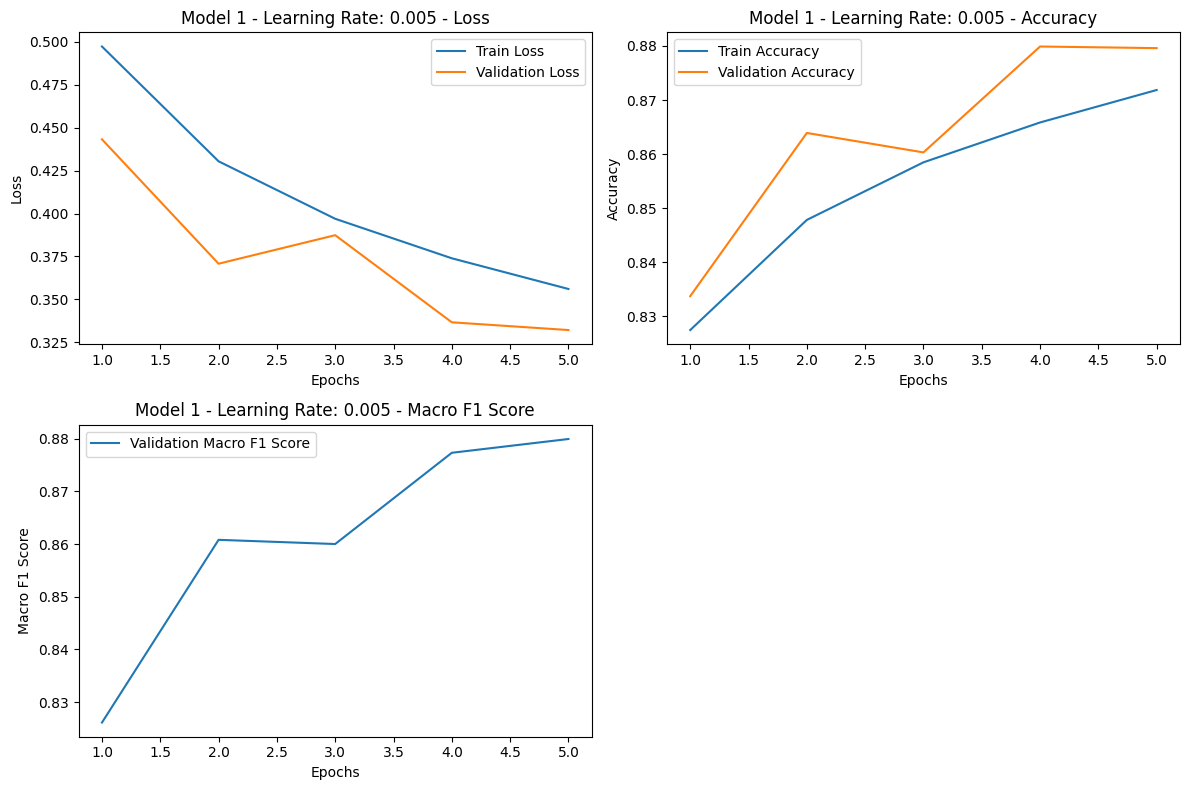

Training Model 1 with learning rate 0.0025


Training Batches:  93%|█████████▎| 876/938 [00:59<00:04, 14.61it/s]


KeyboardInterrupt: 

In [133]:
learning_rates = [0.005, 0.0025, 0.001, 0.00075]
models = [build_model_2, build_model_3]
model_names = ['Model 1', 'Model 2', 'Model 3']
best_model = None
best_f1_score = 0
best_model_name = ""
best_lr = 0

results = []

for model_fn, model_name in zip(models, model_names):
    for lr in learning_rates:
        print(f'Training {model_name} with learning rate {lr}')
        model = model_fn(lr)
        train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores, conf_matrix = train(model, train_dataset, test_dataset, batch_size=64, epochs=5)
        plot_results(train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores, lr, model_name)

        # Store results
        results.append({
            'Model': model_name,
            'Learning Rate': lr,
            'Train Loss': train_losses[-1],
            'Validation Loss': val_losses[-1],
            'Train Accuracy': train_accuracies[-1],
            'Validation Accuracy': val_accuracies[-1],
            'Validation Macro F1 Score': val_f1_scores[-1]
        })

        # Check if this is the best model
        if val_f1_scores[-1] > best_f1_score:
            best_f1_score = val_f1_scores[-1]
            best_model = model
            best_model_name = model_name
            best_lr = lr

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Load the best model
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify that the loaded model works
accuracy, f1, conf_matrix = validate(loaded_model, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}, Macro F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)
plot_confusion_matrix(conf_matrix, best_model_name, best_lr)

# Report the best model
print(f"\nBest Model: {best_model_name} with Learning Rate: {best_lr}")
print(f"Validation Macro F1 Score: {best_f1_score:.4f}")

# Create a DataFrame to display the results
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='Validation Macro F1 Score', ascending=False)

# Highlight the best model
def highlight_best(s):
    return ['background-color: yellow' if v == best_f1_score else '' for v in s]

df_results.style.apply(highlight_best, subset=['Validation Macro F1 Score'])

print(df_results)

## Saving the weights

In [25]:
# Function to extract weights from the model
def extract_weights(model):
    weights = {}
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            weights[f'layer_{i}_weights'] = layer.weights
        if hasattr(layer, 'bias'):
            weights[f'layer_{i}_bias'] = layer.bias
        if hasattr(layer, 'gamma'):
            weights[f'layer_{i}_gamma'] = layer.gamma
        if hasattr(layer, 'beta'):
            weights[f'layer_{i}_beta'] = layer.beta
    return weights

# Function to set weights in the model
def set_weights(model, weights):
    for i, layer in enumerate(model.layers):
        if f'layer_{i}_weights' in weights:
            layer.weights = weights[f'layer_{i}_weights']
        if f'layer_{i}_bias' in weights:
            layer.bias = weights[f'layer_{i}_bias']
        if hasattr(layer, 'gamma'):
            layer.gamma = weights[f'layer_{i}_gamma']
        if hasattr(layer, 'beta'):
            layer.beta = weights[f'layer_{i}_beta']

In [ ]:
# Save the best model weights
weights = extract_weights(best_model)
with open('model_weights_1905068.pkl', 'wb') as f:
    pickle.dump(weights, f)

## Testing the best model

In [27]:
# Load the best model weights
with open('model_weights_1905068.pkl', 'rb') as f:
    loaded_weights = pickle.load(f)

# Set the weights in the model
new_model = build_model_2(0.001)  # or build_model_2 or build_model_3 depending on best_model_name
set_weights(loaded_model, loaded_weights)

# Verify that the loaded model works
loss, accuracy, f1, conf_matrix = validate(loaded_model, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}, Macro F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)
plot_confusion_matrix(conf_matrix, best_model_name, best_lr)

KeyError: 'layer_4_gamma'

In [20]:
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

with open('b1.pkl', 'rb') as b1:
  test_dataset = pickle.load(b1)

In [32]:
# Load the best model weights
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# # Set the weights in the model
# loaded_model = build_model_2(0.001)  # or build_model_2 or build_model_3 depending on best_model_name
# set_weights(loaded_model, loaded_weights)

# Verify that the loaded model works
loss, accuracy, f1, conf_matrix = validate(loaded_model, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}, Macro F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)
# plot_confusion_matrix(conf_matrix, best_model_name, best_lr)

Test Accuracy: 0.2382, Macro F1 Score: 0.0809
Confusion Matrix:
 [[   7    0    1  640    6]
 [   0    0    0  495    0]
 [   0    0    0    0    0]
 [   0    0    0  853    0]
 [   0    0    0 1609    0]]
